In [1]:
import torch
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
%matplotlib inline

In [2]:
import pycuda.driver as cuda
cuda.init()
torch.cuda.current_device()

0

In [3]:
def find_age(filename):
    age = int(filename[filename.index("d/")+2:filename.index("_")])
    try:
        if age <= 19: 
            age = 0
        elif age <=24:
            age = 1
        elif age <= 34:
            age = 2
        elif age <= 44:
            age = 3
        elif age <= 54:
            age = 4
        elif age <= 59:
            age = 5
        elif age <= 64:
            age = 6
        elif age <= 74:
            age = 7
        elif age <= 84:
            age = 8
        else:
            age = 9
    except:
        age = 9
    return age

In [4]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = find_age(self.imgs[index][0])
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [5]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = ImageFolderWithPaths(root="data/", transform=ToTensor())

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create the dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)

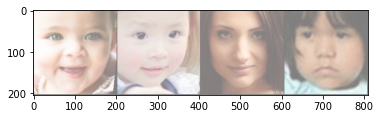

tensor(0)
tensor(0)
tensor(2)
tensor(1)


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import re

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(testloader)
images, idk, filename = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))

for fname in filename:
    print(fname)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        if torch.cuda.is_available(): self.cuda()
        self.conv1 = nn.Conv2d(3, 6, 4)
        self.pool = nn.MaxPool2d(8, 8)
        self.conv2 = nn.Conv2d(6, 16, 4)
        self.fc1 = nn.Linear(16 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)  #age (0 to 1 * 100), gender (<0.5 -> F, >=0.5 -> M), race ((0 to 1) / nraces) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.to(torch.device("cuda:0"))

Net(
  (conv1): Conv2d(3, 6, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=64, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [8]:
#loss_function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
#Training the network
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, _, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()        

        # forward + backward + optimize
        outputs = net(inputs.cuda())
                
        outputs = torch.reshape(outputs, (4,-1))
                
        loss = criterion(outputs, labels.cuda())
        loss.backward()
        optimizer.step()
        

        # print statistics
        running_loss += loss.item()
        if i % 500 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.00116517
[1,   501] loss: 0.49434761
[1,  1001] loss: 0.45779130
[1,  1501] loss: 0.46571757
[2,     1] loss: 0.00084022
[2,   501] loss: 0.46505392
[2,  1001] loss: 0.46345130
[2,  1501] loss: 0.45357806
[3,     1] loss: 0.00069526
[3,   501] loss: 0.45458308
[3,  1001] loss: 0.44414382
[3,  1501] loss: 0.41945321
[4,     1] loss: 0.00059609
[4,   501] loss: 0.41670505
[4,  1001] loss: 0.38948604
[4,  1501] loss: 0.39717997
[5,     1] loss: 0.00076079
[5,   501] loss: 0.37977884
[5,  1001] loss: 0.37706203
[5,  1501] loss: 0.36712628
[6,     1] loss: 0.00078371
[6,   501] loss: 0.36072972
[6,  1001] loss: 0.36091793
[6,  1501] loss: 0.36031494
[7,     1] loss: 0.00075749
[7,   501] loss: 0.36467422
[7,  1001] loss: 0.34622827
[7,  1501] loss: 0.34046500
[8,     1] loss: 0.00085546
[8,   501] loss: 0.33877404
[8,  1001] loss: 0.34060381
[8,  1501] loss: 0.34211363
[9,     1] loss: 0.00084922
[9,   501] loss: 0.33076116
[9,  1001] loss: 0.33570014
[9,  1501] loss: 0.3

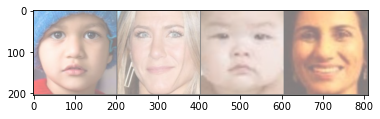

tensor([0, 4, 0, 3])
tensor([0, 4, 0, 2], device='cuda:0')


In [10]:
dataiter = iter(testloader)
pog, something, labels = dataiter.next()
# print images
imshow(torchvision.utils.make_grid(pog))

outputs = net(pog.cuda())
print(labels)

classes = ("Male", "Female")
_, predicted = torch.max(outputs, 1)

print(predicted)


In [11]:
# now im testing for accuracy
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, _, labels = data
        outputs = net(images.cuda())
        _, predicted = torch.max(outputs.cuda(), 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print(correct / total)

0.5178936605316974


In [12]:
PATH = './pth_files/age.pth'
torch.save(net.state_dict(), PATH)